In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import msprime as msp
import tszip
import pathlib
from asmc.asmc import *
from asmc.preparedecoding import *

import os, sys

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

print("numpy version: {}".format(np.__version__)) 
print("msprime version: {}".format(msp.__version__)) 
print("pandas version: {}".format(pd.__version__)) 
print("tszip version: {}\n".format(tszip.__version__))

numpy version: 1.21.2
msprime version: 1.0.2
pandas version: 1.3.3
tszip version: 0.1.0



# Utility / Plotting Functions 

In [2]:
def sim_pop_demography(demo_file):
    """ Simulate a single population. 
        input:
            demo_file - two column file ([Generations,NE]) NOTE: assumed diploid
        output: 
            demography: msp.Demography object
    """
    df = pd.read_table(demo_file, header=None)
    df.columns  = ['GEN', 'NE']
    demography = msp.Demography()
    demography.add_population(name="A", initial_size=1e4)
    for t,n in zip(df.GEN.values, df.NE.values):
        # NOTE: we have to divide because msprime expects a diploid demography for working with VCFs
        demography.add_population_parameters_change(t, initial_size=n/2, population="A")
    return(demography)

In [3]:
def get_true_tmrca(ts, id1, id2, snp_locations=None):
    """ Obtain the true tmrcas between id1 and id2 samples 
        Arguments:
         - ts : tskit Tree-Sequence object
         - id1: int specifying haplotype 1
         - id2: int specifying haplotype 2
         - snp_locations: np.array of snp_locations to test against (default: None)
    """
    if snp_locations is None:
        snp_locations = np.array([s.position for s in ts.sites()])
        assert snp_locations.size > 0
    test_windows = [0.]
    for i in snp_locations:
      test_windows.append(i-0.1)
      test_windows.append(i)
    test_windows.append(ts.sequence_length)
    true_tmrcas = ts.diversity([id1,id2], 
                               mode='branch',
                               windows=test_windows,
                               span_normalise=True)[1::2] / 2
    assert snp_locations.size == true_tmrcas.size
    return(true_tmrcas, snp_locations)

def tmrca_rmse(ts1,ts2):
    """ RMSE between two estimates of tmrca (ts1, ts2)."""
    assert ts1.size == ts2.size
    assert ts1.ndim == ts2.ndim
    assert ts1.ndim == 1
    rmse = np.sqrt(np.nanmean((ts1 - ts2)**2))
    return(rmse)

In [4]:
def plot_yx(ax, **kwargs):
    """Plot the y=x line in a matplotlib axis."""
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against each other
    ax.plot(lims, lims, **kwargs)


def debox(ax):
    """Remove the top and right spines of a plot."""
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
def plot_asmc_single_pair(fig, phys_bp, true_tmrcas, est_tmrcas, labels):
    """ Generate a plot of the undrelying tmrcas and the estimated tmrcas
        NOTE: also generates a scatter plot of true vs estimated tmrcas
        
        Arguments:
        ----------
        - fig: matplotlib.figure for generating the figure.
        - phys_bp: numpy array of positions.
        - true_tmrca: numpy array of true tmrca values.
        - est_tmrcas: list of estimated tmrcas (list of numpy arrays).
        - labels: list of labels for each tract of posterior tmrcas
    """
    assert phys_bp.size == true_tmrca.size
    for x in est_tmrcas:
        assert phys_bp.size == x.size
    assert len(labels) == len(est_tmrcas)
    assert len(est_tmrcas) > 0
    gs = fig.add_gridspec(1, 3)
    ax0 = fig.add_subplot(gs[0, :2])
    ax1 = fig.add_subplot(gs[0, 2])
    # Plot a version of this here ... 
    ax0.step(phys_bp, true_tmrca, label=r'True TMRCA')
    for lbl, est_t in zip(labels, est_tmrcas):
        ax0.step(phys_bp, est_t, label=lbl)
    ax0.set_yscale('log')
    ax0.set_ylabel(r'$T_{MRCA}$')
    ax0.set_xlabel('Position (bp)')
    
    ax0.legend(fontsize=10)
    ax1.scatter(true_tmrca, est_tmrcas[0], 
                s=10, alpha=0.1, 
                label=r'$\frac{T}{\hat{T}}=%0.2f$' % np.nanmedian(true_tmrca/est_tmrcas[0]))
    ax1.set_aspect('equal', adjustable='box')
    ax1.legend()
    ax1.set_xlabel(r'True $T_{MRCA}$')
    ax1.set_ylabel(r'Posterior Mean $T_{MRCA}$')
    plot_yx(ax1, color='r', linestyle='--')
    debox(ax1); debox(ax0);
    return(fig, [ax0,ax1])

# Simulating Ground-Truth Data 

In [5]:
## Parameter Settings

data_dir = pathlib.Path('.').resolve().parent / 'ASMC_data'

outfix = 'test' # this is the outfix for all of our datasets that are output
demo_file = str(data_dir / 'demographies' / 'CEU.demo') # Simulate under the CEU demography for now ...  

demography = sim_pop_demography(demo_file) # Generate a demography using a constant size ... 

# Simulate 150 diploid samples 
ts = msp.sim_ancestry(samples={"A": 300}, 
                      demography=demography, 
                      sequence_length=10e6, 
                      recombination_rate=1e-8, 
                      ploidy=2, #this is very important as msprime is diploid by default!
                      random_seed=42)

mts = msp.sim_mutations(ts, 
                        rate=1e-8, 
                        random_seed=42, 
                        model=msp.BinaryMutationModel())

# Save the tree-sequence as a zipped file for now 
tszip.compress(mts, f"{outfix}.ts.tsz")

In [6]:
# Convert our zipped tree-sequence to a haps.gz file with our outfix  
os.system("tszip -d -k --force {}.ts.tsz".format(outfix))
os.system("tskit vcf {}.ts | bcftools view -v snps -m2 -M2 | \
    bcftools +fill-tags | bgzip -@8 > {}.vcf.gz".format(outfix, outfix))
os.system("echo -e \"CHR\tSNP\tA1\tA2\tMAF\tNCHROBS\" > {}.seq.frq; \
    bcftools query -f \"%CHROM\t%ID\t%REF\t%ALT\t%MAF\t%AN\n\" {}.vcf.gz >> {}.seq.frq".format(outfix,outfix, outfix))
os.system("tabix -f {}.vcf.gz".format(outfix))
os.system("bcftools query -f \'%CHROM\t%ID\t%POS\n\' \
    {}.vcf.gz  | awk \'{{OFS=\"\t\"; print $1,$2,(2E-8 * $3 *100),$3}}\' | bgzip -@4 > {}.seq.map.gz".format(outfix, outfix))
os.system("bcftools convert --hapsample {}.seq.hap.gz,{}.seq.samples {}.vcf.gz".format(outfix, outfix, outfix));

Hap file: test.seq.hap.gz
Sample file: test.seq.samples
38124 records written, 0 skipped: 0/0/0 no-ALT/non-biallelic/filtered


In [7]:
%%time
## Generating the decoding quantities just for this simulation (based on the sequencing data)
dq = prepare_decoding(
    demography=demo_file,
    discretization=[[30.0, 15], [100.0, 15], 39], # 15 blocks of 30 generations, 15 blocks of 100 generations, 39 quantiles...
    frequencies=f"{outfix}.seq.frq",
    samples=100,
    mutation_rate=1e-8)
dq.save_decoding_quantities(f"{outfix}")

Demography set to file /Users/aabiddanda/Repos/ASMC_dev/ASMC_data/demographies/CEU.demo
Frequencies file set to test.seq.frq
New CSFS will be calculated
Using the following pre-specified discretization intervals: {0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 550, 650, 750, 850, 950, 1050, 1150, 1250, 1350, 1450, 1550, 1650, 1750, 1850, 1950}
 and calculating 39 additional intervals from coalescent distribution.
smcpp: init_cache() successful
Will use minor allele frequencies from test.seq.frq ...
Will use mutation rate mu = 1e-08.
Number of samples in CSFS calculations: 100.
Verified 70 CSFS entries.
Probability of a site being monomorphic due to subsampling: 0.435997451410626

Building decoding quantities...
CPU times: user 29 s, sys: 268 ms, total: 29.3 s
Genetic distances pWall time: 13 s


Genetic distances progress: 100%	
Physical distances progress: 100%	
Read 300 samples.
Read data for 600 haploid samples and 38124 markers, 12 of which are monomorphic. This job will focus on 600 haploid samples.
Using precomputed decoding info from test.decodingQuantities.gz


/Users/aabiddanda/.pyenv/versions/3.9.1/envs/venv_asmc/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


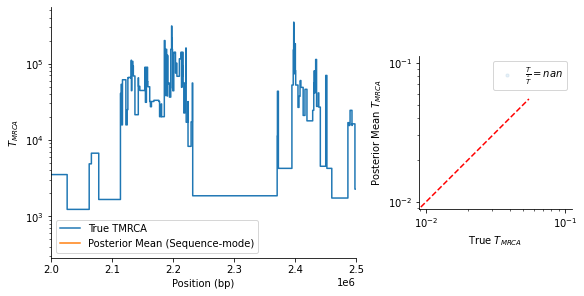

In [8]:
id1, id2 = 1,2

asmc_seq = ASMC(f"{outfix}.seq", f"{outfix}.decodingQuantities.gz", decoding_mode="sequence")
asmc_seq.set_store_per_pair_posterior_mean(True)
asmc_seq.set_store_per_pair_map(True)
# We'll just decode for a single pair?
asmc_seq.decode_pairs([id1],[id2])
return_seq = asmc_seq.get_copy_of_results()

# Plotting Results... 
fig = plt.figure(constrained_layout=True, figsize=(8,4))
true_tmrca, phys_bp = get_true_tmrca(mts, id1=id1, id2=id2)
posterior_mean_tmrca_seq = return_seq.per_pair_posterior_means[0]
_, [ax0, ax1] = plot_asmc_single_pair(fig, phys_bp, true_tmrca, 
                                      [posterior_mean_tmrca_seq], 
                                      ['Posterior Mean (Sequence-mode)'])
# Only show a limited view of the posterior decoding 
ax0.set_xlim(2e6, 2.5e6);
ax1.set_yscale('log'); ax1.set_xscale('log');